In [ ]:
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Path handling
from pathlib import Path

### Step 1: Load Clean Dataset

In [ ]:
df = pd.read_csv("churn_clean.csv")
df.head()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Step 2: Data Preprocessing

In [ ]:
# Separate features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

In [ ]:
# Identify categorical columns
cat_cols = X.select_dtypes(include='object').columns
cat_cols

Index(['Geography', 'Gender'], dtype='object')

In [ ]:
# Identify numerical columns
num_cols = X.select_dtypes(exclude='object').columns
num_cols 

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [ ]:
# Column transformer
ct = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first'), cat_cols),
    ('scaler', StandardScaler(), num_cols)
])

X_prepared = ct.fit_transform(X)

### Step 3: Split the dataset into training and test sets

In [ ]:
# First split: 60% train, 40% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_prepared,
    y,
    test_size=0.4,        # 40% kept for validation + test
    stratify=y,
    random_state=42
)


In [ ]:
# Second split: split the remaining 40% equally into validation and test (20% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,        # half of 40% -> 20%
    stratify=y_temp,
    random_state=42
)

In [ ]:
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)
print("y_train ratio:", y_train.mean().round(3))
print("y_val   ratio:", y_val.mean().round(3))
print("y_test  ratio:", y_test.mean().round(3))


Training set shape: (6000, 11)
Validation set shape: (2000, 11)
Test set shape: (2000, 11)
y_train ratio: 0.204
y_val   ratio: 0.204
y_test  ratio: 0.204


### Step 4：Baseline Model: Logistic Regression

In [ ]:
# Build the model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
# Make predictions
y_val_pred = log_reg.predict(X_val)
y_val_proba = log_reg.predict_proba(X_val)[:, 1]
y_test_pred = log_reg.predict(X_test)
y_test_proba = log_reg.predict_proba(X_test)[:, 1]


In [ ]:
print("Validation ROC-AUC:", round(roc_auc_score(y_val, y_val_proba), 3))
print(classification_report(y_val, y_val_pred))

print("Test ROC-AUC:", round(roc_auc_score(y_test, y_test_proba), 3))
print(classification_report(y_test, y_test_pred))


Validation ROC-AUC: 0.794
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1592
           1       0.40      0.75      0.52       408

    accuracy                           0.72      2000
   macro avg       0.66      0.73      0.66      2000
weighted avg       0.81      0.72      0.74      2000

Test ROC-AUC: 0.773
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1593
           1       0.37      0.70      0.49       407

    accuracy                           0.70      2000
   macro avg       0.64      0.70      0.64      2000
weighted avg       0.79      0.70      0.73      2000



### Step 5: Model Evaluation & Plots

In [ ]:
# Create output folder
FIG_DIR = Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

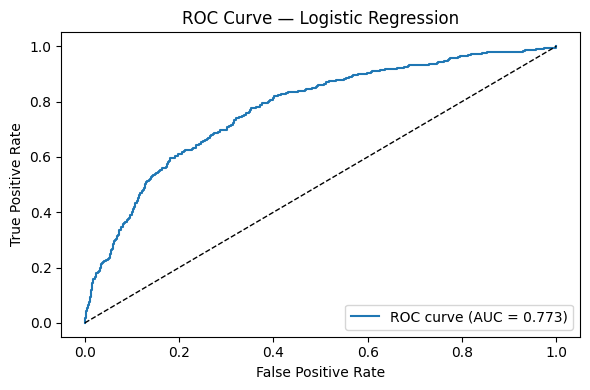

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(FIG_DIR / "roc_curve_logreg.png", dpi=200)
plt.show()

In [ ]:
# Precision–Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_test_proba)
ap = average_precision_score(y_test, y_test_proba)

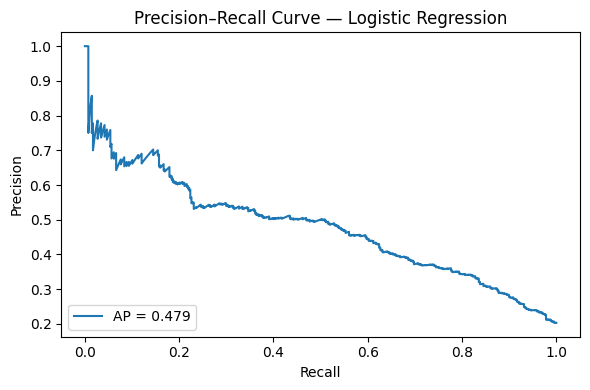

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Logistic Regression")
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig(FIG_DIR / "pr_curve_logreg.png", dpi=200)
plt.show()

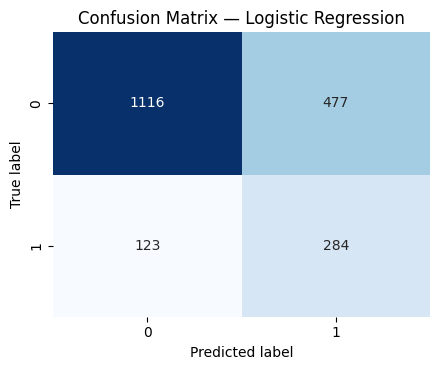

In [ ]:
# Confusion Matrix 
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(4.5, 3.8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig(FIG_DIR / "confusion_matrix_logreg.png", dpi=200)
plt.show()